In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import joblib
from os.path import isfile

# %matplotlib notebook
from matplotlib import pyplot as plt

from os.path import join
from jupyter_utils.progress_bar import ProgressBar
from functools import partial

from nabirds import CUB_Annotations, NAB_Annotations, Dataset
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import resize

from prettytable import PrettyTable
from tqdm import tqdm

In [3]:
BASE_DIR = "/home/korsch/Data"

infos = dict(
    
    # VGG19 Features
    
    NAC_single=dict(
        data="NAC/2017-bilinear",
        feat_suffix="10parts_new"
    ),
    
    NAC_vgg=dict(
        data="NAC/2017-bilinear",
        feat_suffix="20parts"
    ),
    
    
    # ResNet50 Features
    
    NAC_resnet=dict(
        data="NAC/2017-bilinear",
        feat_suffix="20parts.resnet"
    ),
    
    GT_resnet=dict(
        data="cub200_11",
        feat_suffix="16parts_gt.resnet"
    ),
    
    # InceptionV3 Features
    
    NAC_inception=dict(
        data="NAC/2017-bilinear",
        feat_suffix="20parts.inception"
    ),
    
    GT_inception=dict(
        data="cub200_11",
        feat_suffix="16parts_gt.inception"
    ),
    
    GT2_inception=dict(
        data="cub200_11_regrouped",
        feat_suffix="5parts_gt.inception"
    )
)
DATASET="GT_inception"
info = infos[DATASET]
DATA_DIR = join(BASE_DIR, "DATASETS", "birds", info["data"])


In [4]:
print("Loading annotations from \"{}\"...".format(DATA_DIR))
annot = CUB_Annotations(DATA_DIR)

print("Creating train and test datasets")
splits = [annot.train_uuids, annot.test_uuids]
features = [join(DATA_DIR, "features", "{}_{}.npz".format(s, info["feat_suffix"])) 
            for s in ["train", "val"]]

train, val = [
    Dataset(
        uuids=s, 
        annotations=annot, 
        features=feats,
    ) for s, feats in zip(splits, features)]

data = val

Loading annotations from "/home/korsch/Data/DATASETS/birds/cub200_11"...
Creating train and test datasets


In [5]:
scaler = MinMaxScaler()
scaler.fit(train.features[:, -1])

MinMaxScaler(copy=True, feature_range=(0, 1))

Validation Accuracy: 87.3317%
Validation Accuracy (Top5): 95.5299%


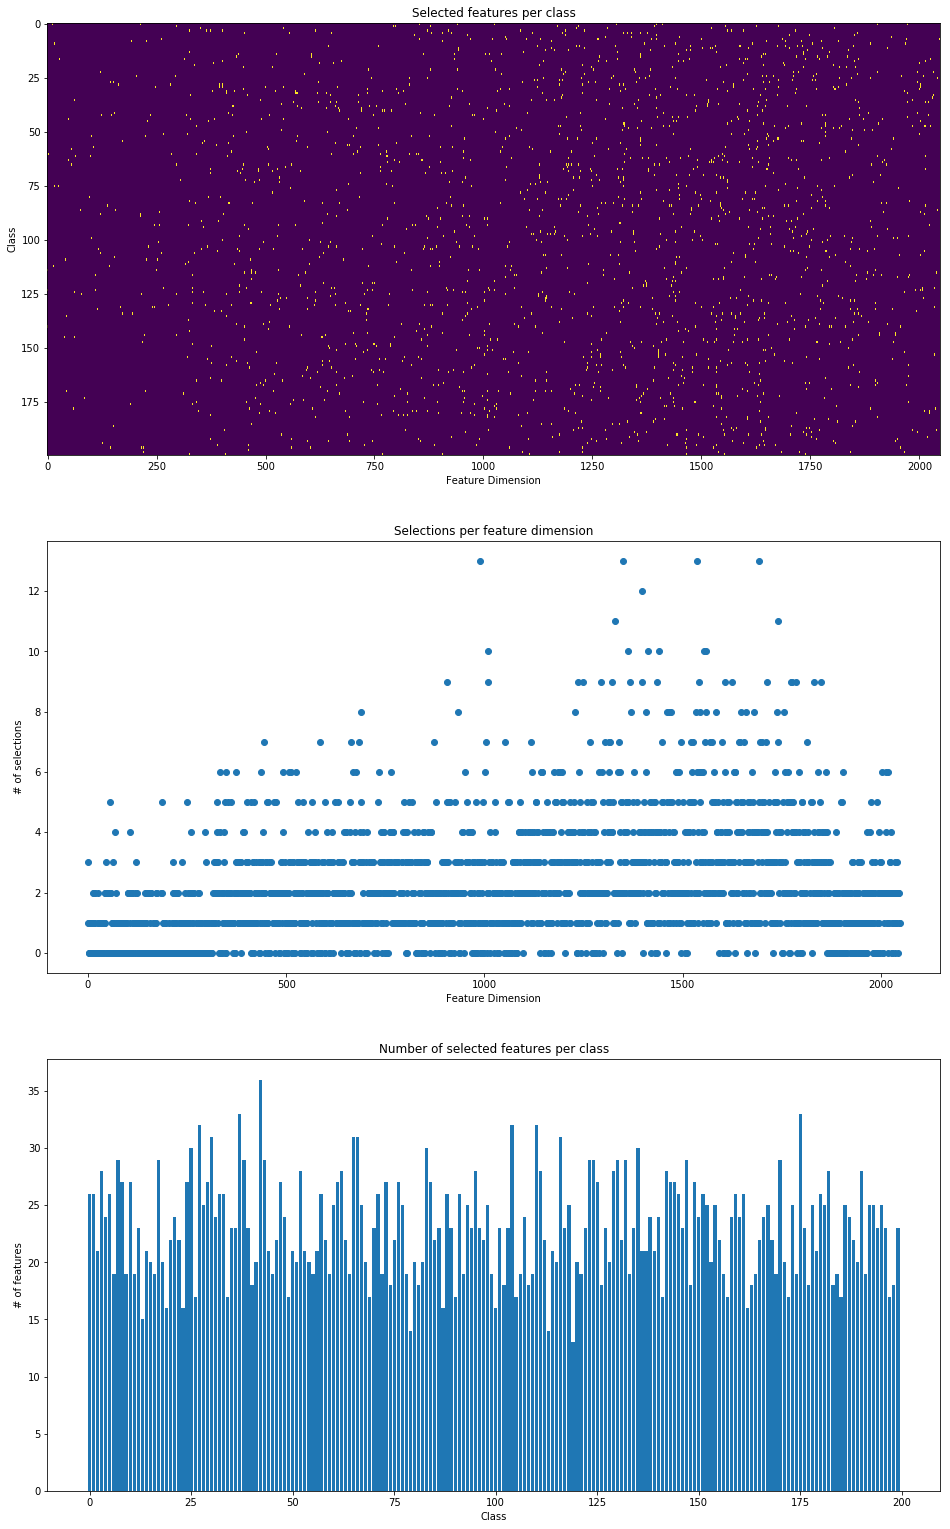

In [7]:
X = scaler.transform(data.features[:, -1])
y = data.labels
clf = joblib.load("clf_{}_glob_only_sparse_coefs.npz".format(DATASET))

COEFS = clf.coef_

print("Validation Accuracy: {:.4%}".format(clf.score(X, y)))

decs = clf.decision_function(X)
top5_preds = np.argsort(decs)[:, -5:]
top5_accu = (top5_preds == np.expand_dims(y, 1)).max(axis=1).mean()
print("Validation Accuracy (Top5): {:.4%}".format(top5_accu))


fig, ax = plt.subplots(3, 1, figsize=(16, 9*3))
ax[0].set_title("Selected features per class")
ax[0].set_xlabel("Feature Dimension")
ax[0].set_ylabel("Class")
ax[0].imshow(clf.coef_ != 0, aspect="auto")

ax[1].set_title("Selections per feature dimension")
ax[1].set_xlabel("Feature Dimension")
ax[1].set_ylabel("# of selections")
# ax[1].imshow((clf.coef_ != 0).sum(axis=0, keepdims=True), aspect="auto")
ax[1].scatter(range(clf.coef_.shape[1]), (clf.coef_ != 0).sum(axis=0))

ax[2].set_title("Number of selected features per class")
ax[2].set_xlabel("Class")
ax[2].set_ylabel("# of features")
ax[2].bar(range(len(clf.coef_)), (clf.coef_ != 0).sum(axis=1))
plt.show()
plt.close()

print()

# Variance of the Features Selected by the L1-SVM

In [8]:
classes = np.unique(val.labels)
tab = PrettyTable()

tab.field_names = ["Class", "Variance (Class)", "Variance (Rest)", "Variance (All)"]

for cls in ProgressBar()(classes):
    cls_mask = val.labels == cls
    rest_mask = np.logical_not(cls_mask)
    cls_coefs = COEFS[cls] != 0
    
    cls_feats = val.features[:, -1, cls_coefs]
    
    tab.add_row([cls, 
        "{:.3f}".format(cls_feats[cls_mask].var(axis=1).mean()), 
        "{:.3f}".format(cls_feats[rest_mask].var(axis=1).mean()), 
        "{:.3f}".format(cls_feats.var(axis=1).mean())
    ])

print(tab, file=open("feature_variance_{}.txt".format(DATASET), "w"))

# Variance of Cropped Parts

In [12]:
from nabirds.dataset import AnnotationsReadMixin, PartMixin

class PartDataset(PartMixin, AnnotationsReadMixin):
    pass

split = annot.train_split
size = (64, 64)
_resize = partial(resize, 
                  output_shape=size, 
                  order=3,
                  mode="edge",
                  anti_aliasing=True)

im_bar = ProgressBar()
def extract_parts(data):
    global size, im_bar
    n_parts = len(data._annot.part_name_list)

    res = np.full(
        shape=(len(data), n_parts) + size, 
        fill_value=np.nan,
        dtype=np.float32)
    
    for i, im_obj  in enumerate(im_bar(data)):
        idxs, _ = im_obj.visible_part_locs()
        part_crops = im_obj.part_crops(ratio=0.1).im
        part_crops = np.array([_resize(part).mean(axis=2) for part in part_crops])
        res[i, idxs] = part_crops
    
    return res

parts_data = PartDataset(
        uuids=annot.train_uuids, 
        annotations=annot, 
        part_rescale_size=224 if "NAC" in DATASET else None
    )
PARTS_DUMP = "all_parts_{}.npy".format(DATASET)
if not isfile(PARTS_DUMP):
    all_parts = extract_parts(parts_data)
    np.save(PARTS_DUMP, all_parts)
else:
    all_parts = np.load(PARTS_DUMP)

In [13]:
tab = PrettyTable()

tab.field_names = ["Class"] + annot.part_name_list

%time all_parts_var = np.nanstd(all_parts, axis=0).mean(axis=(1, 2))
tab.add_row(["All Classes"] + ["{:.3f}".format(var) for var in all_parts_var])

classes_bar = ProgressBar()
rows = []
for cls in classes_bar(classes):
    cls_mask = parts_data.labels == cls
    rest_mask = np.logical_not(cls_mask)
    
    cls_parts = all_parts[cls_mask]
    # rest_parts = all_parts[rest_mask]
        
    cls_parts_var = np.nanstd(cls_parts, axis=0).mean(axis=(1, 2))
    rows.append(cls_parts_var)
    # rest_parts_var = np.nanstd(rest_parts, axis=0).mean(axis=(1, 2))
    
    row = [cls]
    row.extend(["{:.3f}".format(var) for var in cls_parts_var])
                # for var in zip(cls_parts_var, rest_parts_var)])
    tab.add_row(row)


CPU times: user 3.34 s, sys: 1.19 s, total: 4.53 s
Wall time: 2.3 s


/home/korsch/.anaconda3/envs/chainer4/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/korsch/.anaconda3/envs/chainer4/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1547: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var, out=var)


In [14]:
print(tab, file=open("part_variances_{}.txt".format(DATASET), "w"))

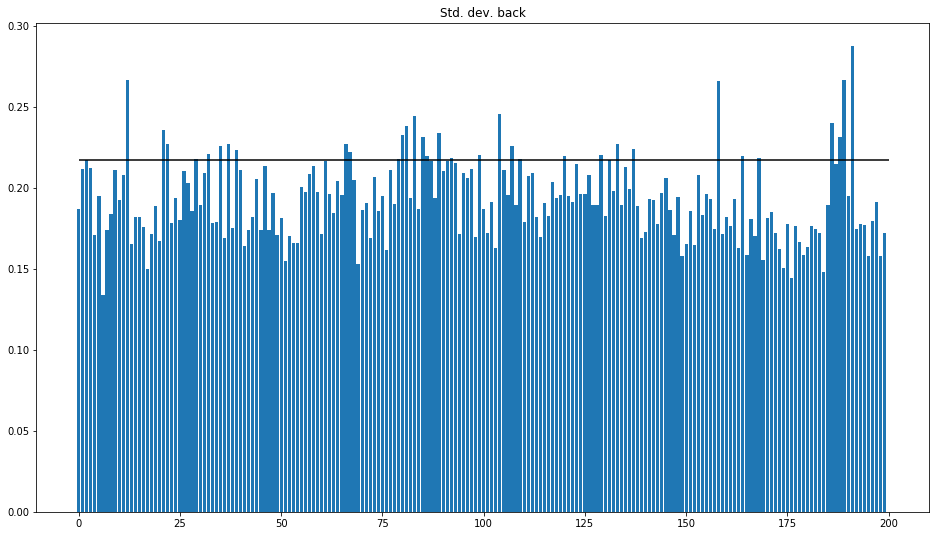

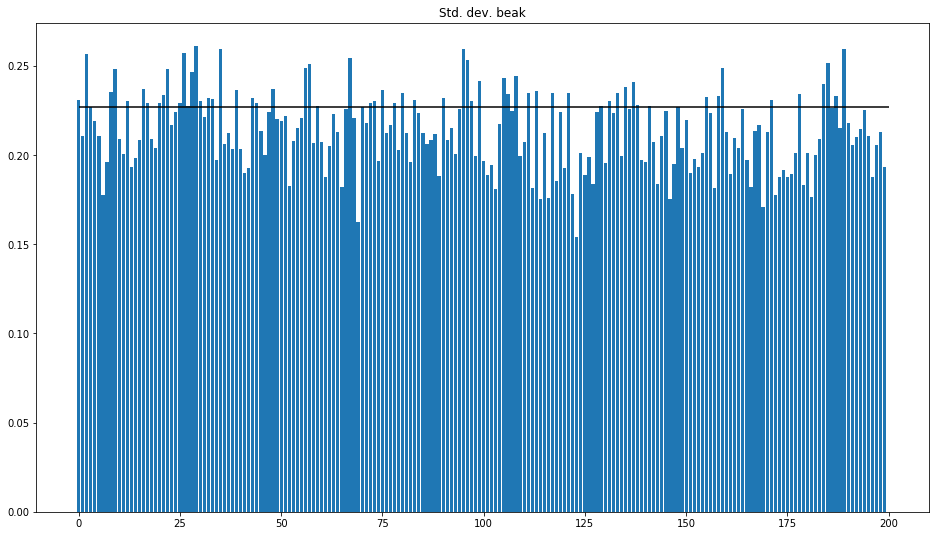

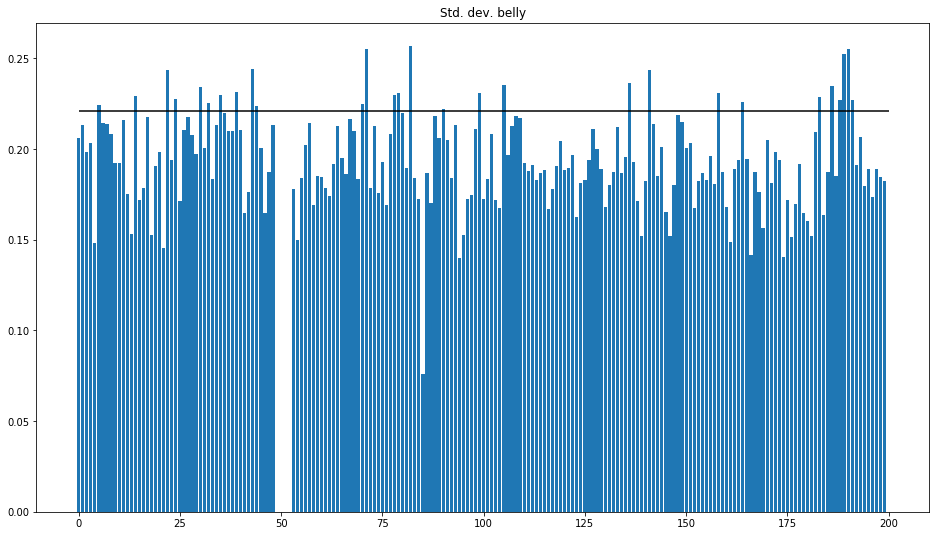

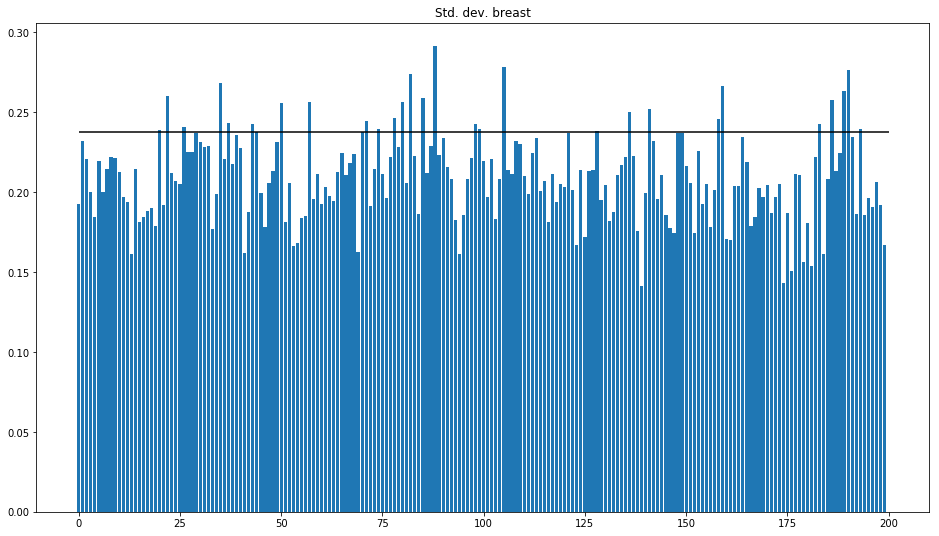

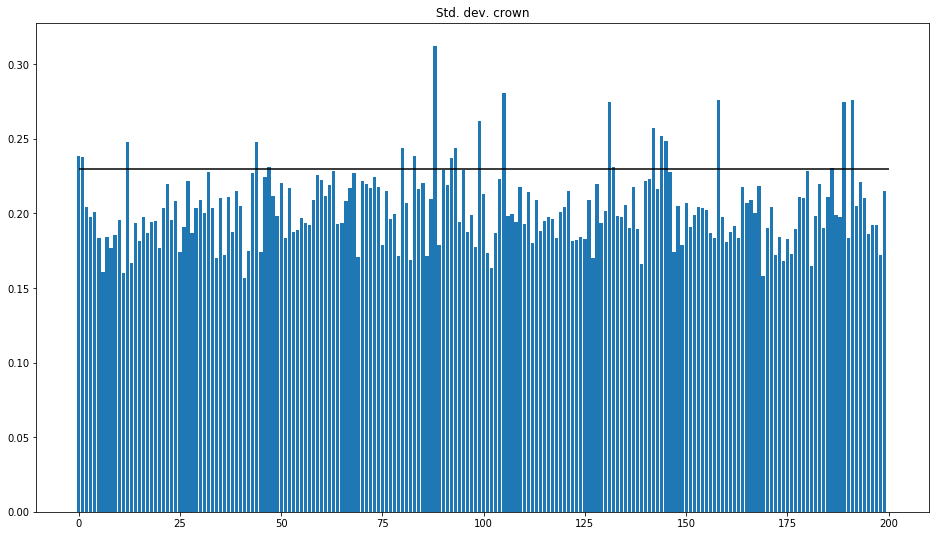

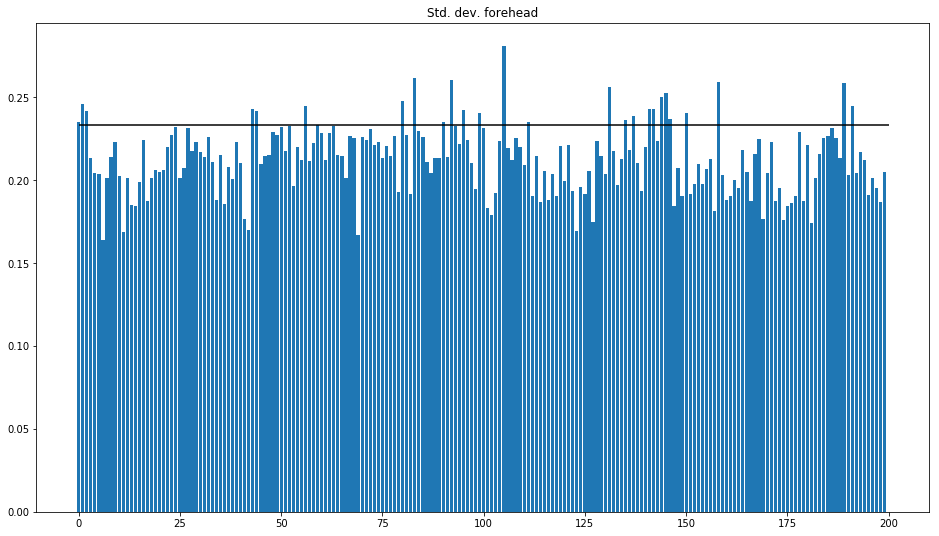

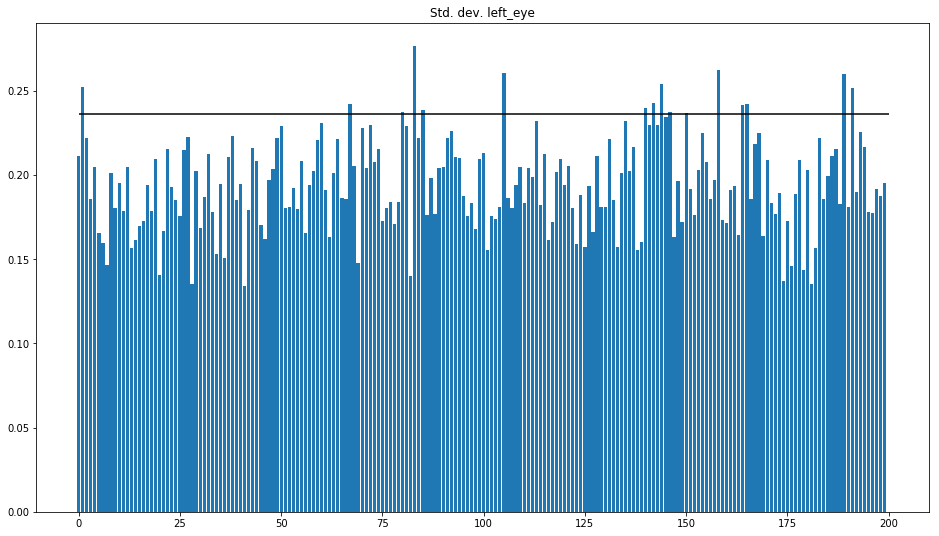

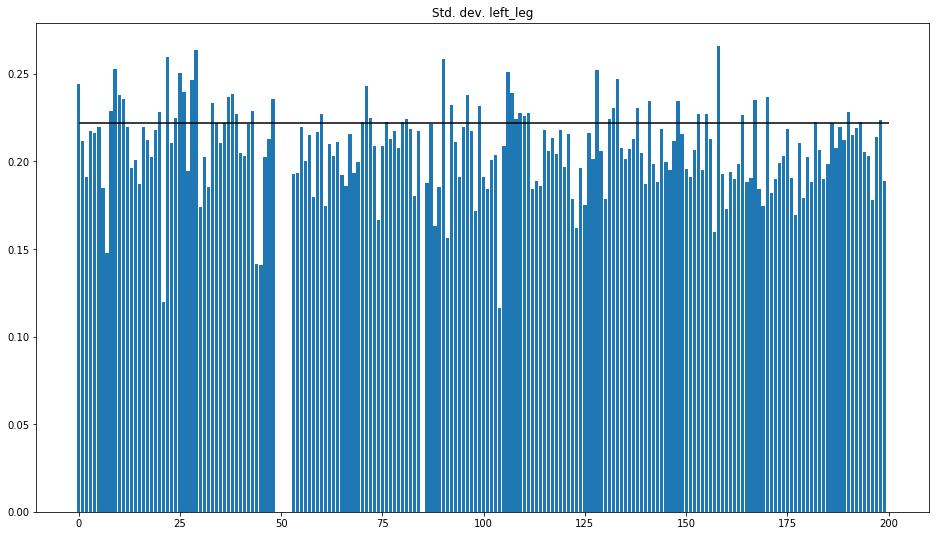

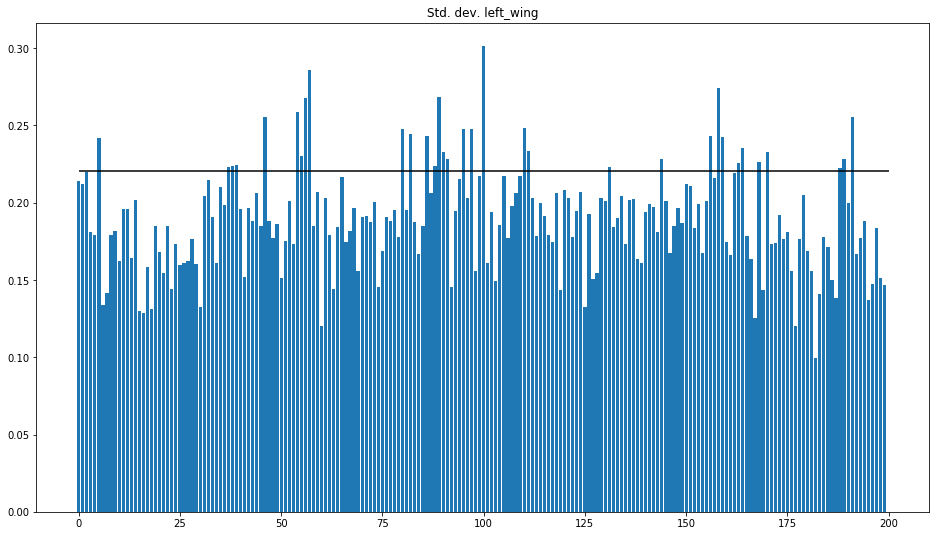

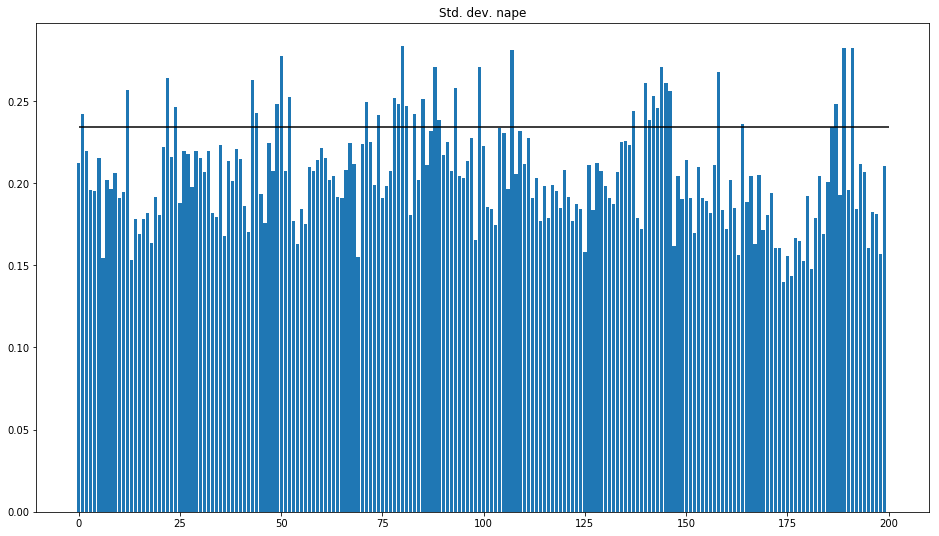

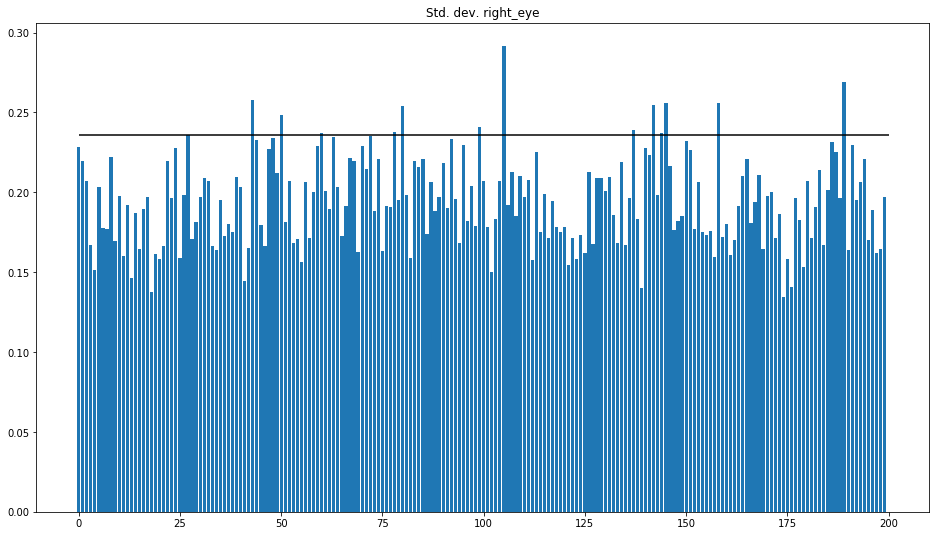

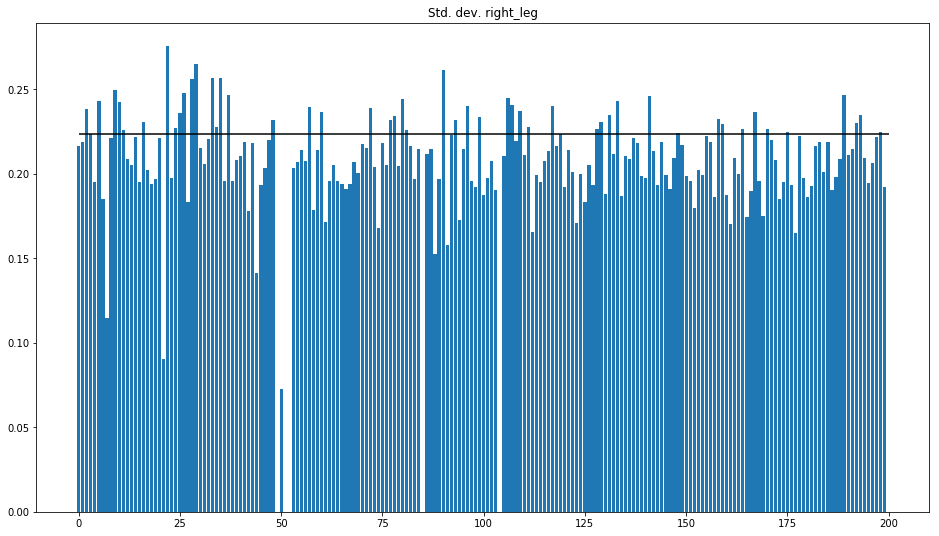

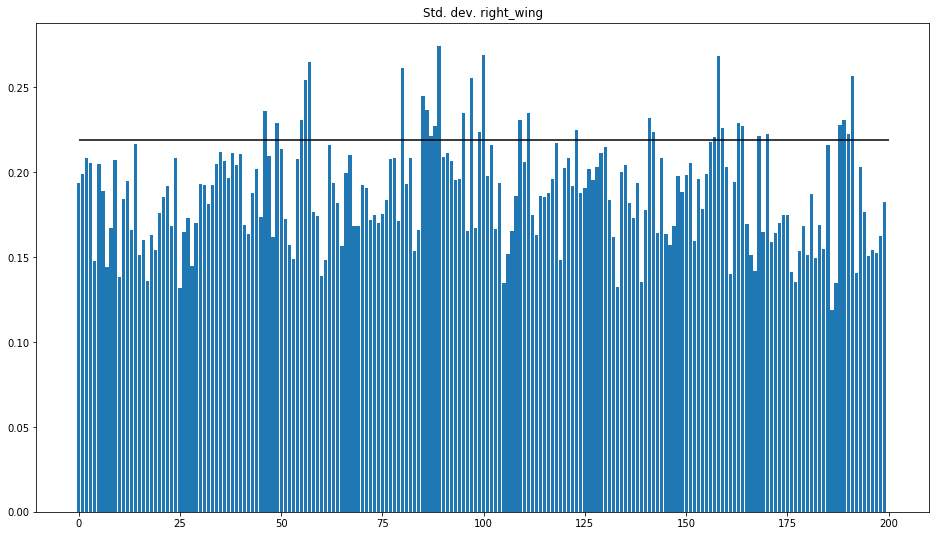

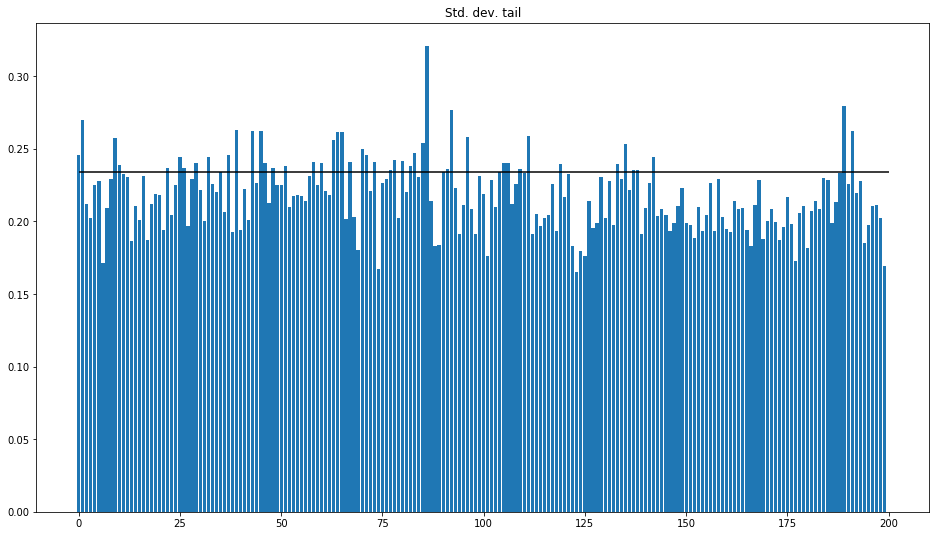

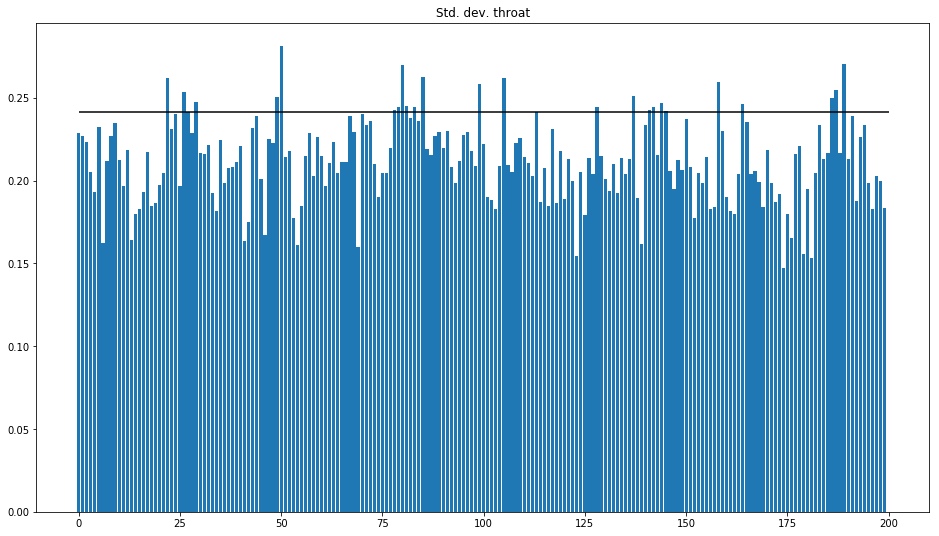

In [15]:
for i, (all_var, cls_vars) in enumerate(zip(all_parts_var, np.array(rows).T)):
    fix, ax = plt.subplots(figsize=(16,9))
    ax.bar(range(len(cls_vars)), cls_vars)
    ax.set_title("Std. dev. {}".format(annot.part_name_list[i]))
    ax.hlines(all_var, xmin=0, xmax=len(cls_vars))
    
    plt.show()
    plt.close()